<a href="https://colab.research.google.com/github/yasinsoylu1997/64-64-UnderSampler/blob/main/vgg19_models_224_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

     |████████████████████████████████| 992 kB 9.5 MB/s 
     |████████████████████████████████| 76.6 MB 160 kB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 64
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:15<00:00, 88.55it/s] 


In [5]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,64,64,3)
oversampled_y

array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

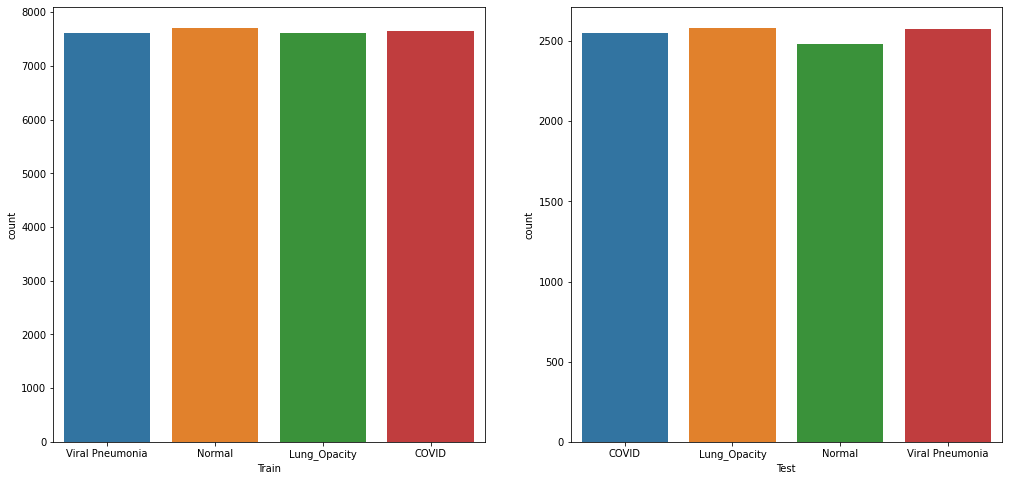

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [13]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

80150528/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

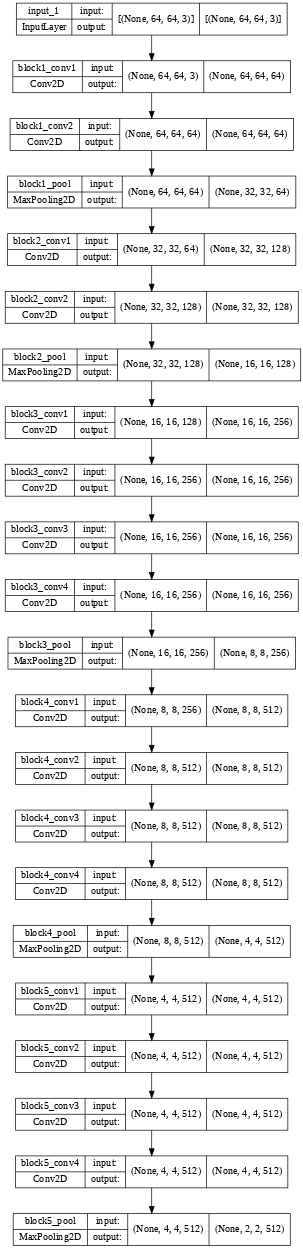

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

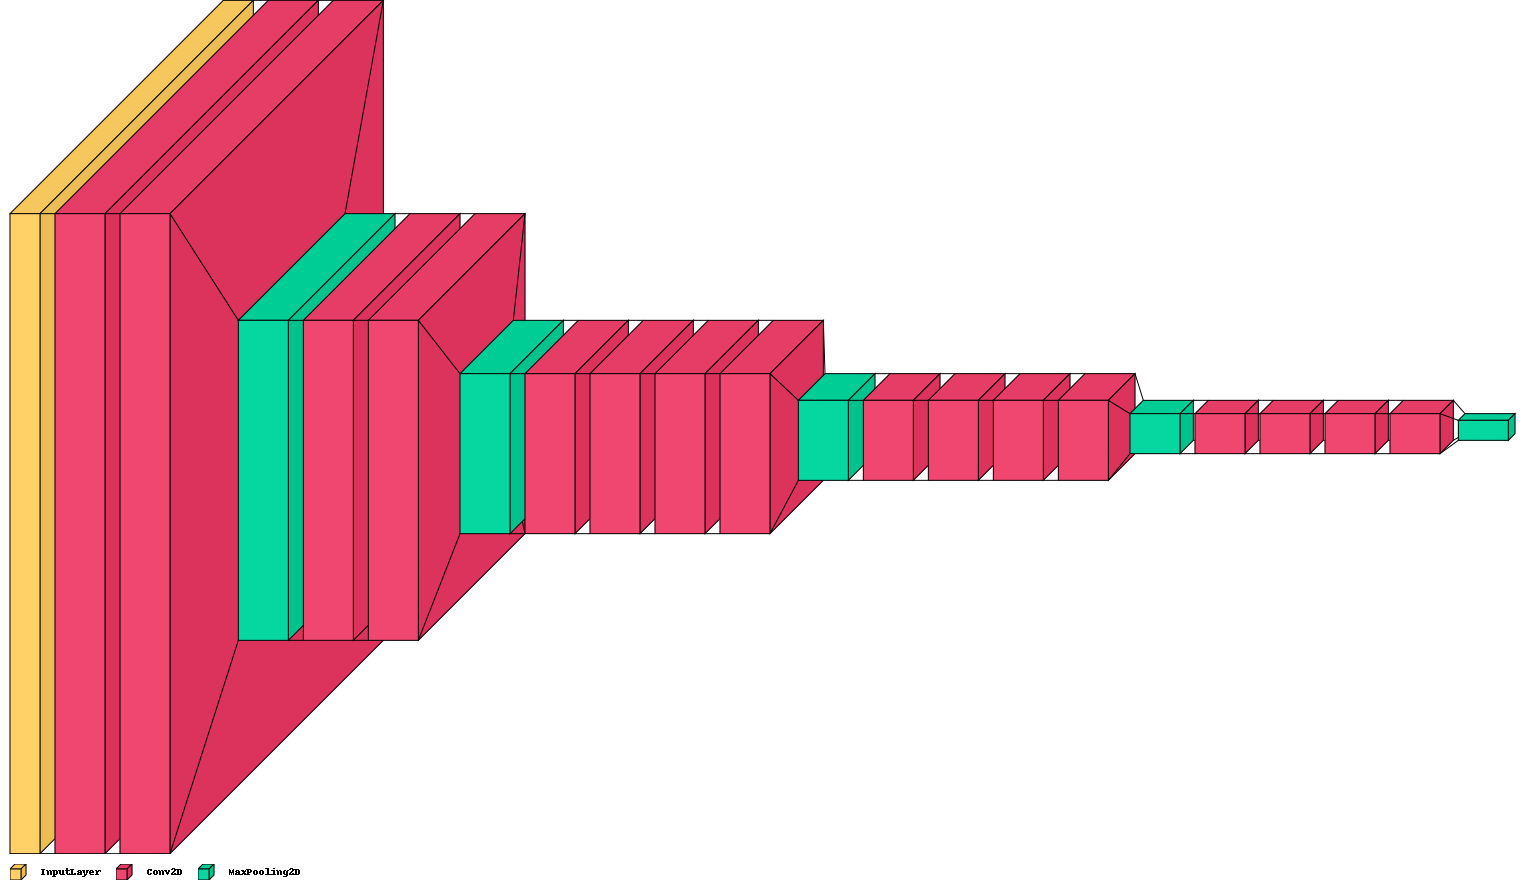

<Figure size 144x144 with 0 Axes>

In [16]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2656004709576138
MSE: 0.40198194662480374
RMSE: 0.6340204623076481
R2 Square 0.6800216695564747
Accuracy 0.8007260596546311
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.2656,0.401982,0.63402,0.680022,0.800726


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.80      0.75      2550
           1       0.78      0.69      0.74      2583
           2       0.74      0.72      0.73      2481
           3       0.96      0.99      0.97      2578

    accuracy                           0.80     10192
   macro avg       0.80      0.80      0.80     10192
weighted avg       0.80      0.80      0.80     10192



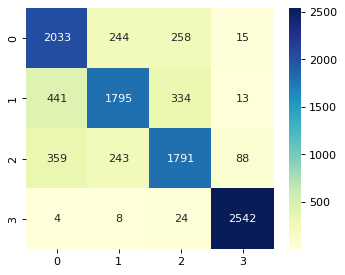

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [25]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.17749215070643642
MSE: 0.26520800627943486
RMSE: 0.5149835009778807
R2 Square 0.7888939645621555
Accuracy 0.8662676609105181
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2550
           1       0.83      0.83      0.83      2583
           2       0.84      0.71      0.77      2481
           3       0.97      1.00      0.98      2578

    accuracy                           0.87     10192
   macro avg       0.87      0.86      0.86     10192
weighted avg       0.87      0.87      0.86     10192



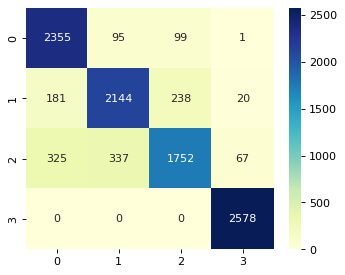

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [30]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [31]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3071036106750393
MSE: 0.48390894819466246
RMSE: 0.6956356432750284
R2 Square 0.6148076334519241
Accuracy 0.777276295133438
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.65      0.69      2550
           1       0.72      0.78      0.75      2583
           2       0.72      0.73      0.73      2481
           3       0.93      0.94      0.94      2578

    accuracy                           0.78     10192
   macro avg       0.78      0.78      0.78     10192
weighted avg       0.78      0.78      0.78     10192



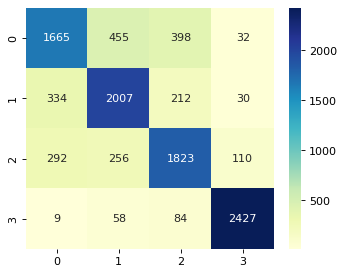

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [37]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.1482535321821036
MSE: 0.21948587127158556
RMSE: 0.4684931923428403
R2 Square 0.8252888637534376
Accuracy 0.8873626373626373
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2550
           1       0.86      0.86      0.86      2583
           2       0.85      0.82      0.83      2481
           3       0.98      1.00      0.99      2578

    accuracy                           0.89     10192
   macro avg       0.89      0.89      0.89     10192
weighted avg       0.89      0.89      0.89     10192



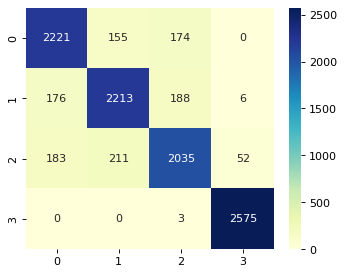

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [43]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.09350470957613814
MSE: 0.12725667189952905
RMSE: 0.3567305312130279
R2 Square 0.8987034672723329
Accuracy 0.9233712715855573
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363
4,RandomForestClassifier,0.093505,0.127257,0.356731,0.898703,0.923371


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2550
           1       0.88      0.90      0.89      2583
           2       0.89      0.84      0.86      2481
           3       0.99      1.00      0.99      2578

    accuracy                           0.92     10192
   macro avg       0.92      0.92      0.92     10192
weighted avg       0.92      0.92      0.92     10192



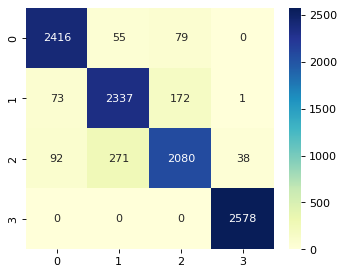

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [48]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [49]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5747645211930926
MSE: 0.810243328100471
RMSE: 0.9001351721272038
R2 Square 0.3550448980223012
Accuracy 0.5354199372056515
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363
4,RandomForestClassifier,0.093505,0.127257,0.356731,0.898703,0.923371
5,GaussianNB,0.574765,0.810243,0.900135,0.355045,0.535420


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.15      0.25      2550
           1       0.44      0.87      0.59      2583
           2       0.47      0.58      0.52      2481
           3       0.91      0.54      0.68      2578

    accuracy                           0.54     10192
   macro avg       0.63      0.53      0.51     10192
weighted avg       0.63      0.54      0.51     10192



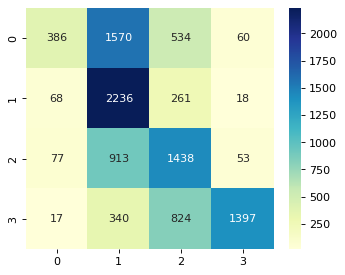

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [54]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [55]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2566718995290424
MSE: 0.4118916797488226
RMSE: 0.641787877533397
R2 Square 0.6721335047102954
Accuracy 0.8176020408163265
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363
4,RandomForestClassifier,0.093505,0.127257,0.356731,0.898703,0.923371
5,GaussianNB,0.574765,0.810243,0.900135,0.355045,0.535420
6,SGDClassifier,0.256672,0.411892,0.641788,0.672134,0.817602


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      2550
           1       0.80      0.79      0.79      2583
           2       0.77      0.78      0.77      2481
           3       0.99      0.91      0.95      2578

    accuracy                           0.82     10192
   macro avg       0.82      0.82      0.82     10192
weighted avg       0.82      0.82      0.82     10192



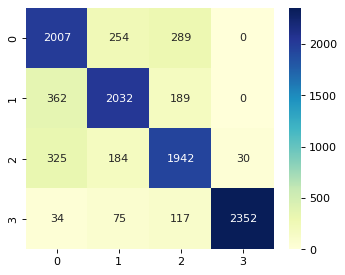

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [60]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [61]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.20398351648351648
MSE: 0.31308869701726844
RMSE: 0.5595432932466159
R2 Square 0.750780851245963
Accuracy 0.8502747252747253
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363
4,RandomForestClassifier,0.093505,0.127257,0.356731,0.898703,0.923371
5,GaussianNB,0.574765,0.810243,0.900135,0.355045,0.535420
6,SGDClassifier,0.256672,0.411892,0.641788,0.672134,0.817602
7,SVC,0.203984,0.313089,0.559543,0.750781,0.850275


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2550
           1       0.83      0.80      0.82      2583
           2       0.80      0.82      0.81      2481
           3       0.98      0.99      0.99      2578

    accuracy                           0.85     10192
   macro avg       0.85      0.85      0.85     10192
weighted avg       0.85      0.85      0.85     10192



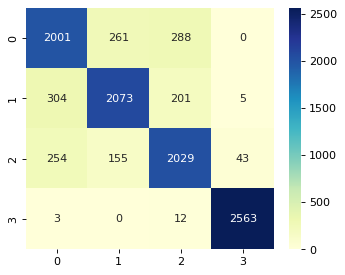

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [66]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [67]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_vgg19"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_vgg19"])
    sonuclar = sonuclar.append(sonuc)
    

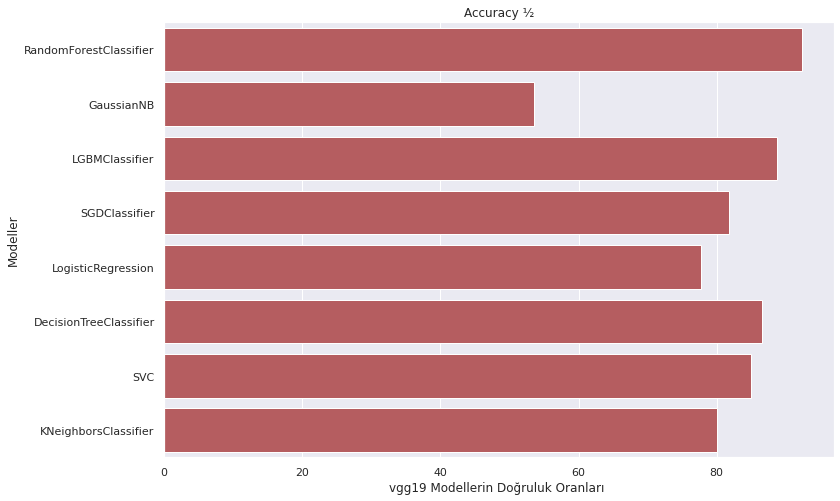

In [68]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_vgg19', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('vgg19 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [69]:
best_acc=sonuclar.sort_values(by=['Accuracy_vgg19'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_vgg19
0,RandomForestClassifier,92.337127


In [70]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.265600,0.401982,0.634020,0.680022,0.800726
1,DecisionTreeClassifier,0.177492,0.265208,0.514984,0.788894,0.866268
2,LogisticRegression,0.307104,0.483909,0.695636,0.614808,0.777276
3,LGBMClassifier,0.148254,0.219486,0.468493,0.825289,0.887363
4,RandomForestClassifier,0.093505,0.127257,0.356731,0.898703,0.923371
5,GaussianNB,0.574765,0.810243,0.900135,0.355045,0.535420
6,SGDClassifier,0.256672,0.411892,0.641788,0.672134,0.817602
7,SVC,0.203984,0.313089,0.559543,0.750781,0.850275


In [71]:
from google.colab import files

results_df.to_csv('output_vgg19.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>